# Trabalho de busca

# Implementação do grafo

###Bibliotecas necessárias

In [ ]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 2.2 MB/s eta 0:00:00


In [ ]:
import osmnx as ox
import networkx as nx
import geopy.distance
import matplotlib.pyplot as plt
import datetime

###Funções

In [ ]:
cidade = 'Sao Carlos, Brazil'

# Baixando o mapa da São Carlos
mapa = ox.graph_from_place(cidade, network_type='drive')

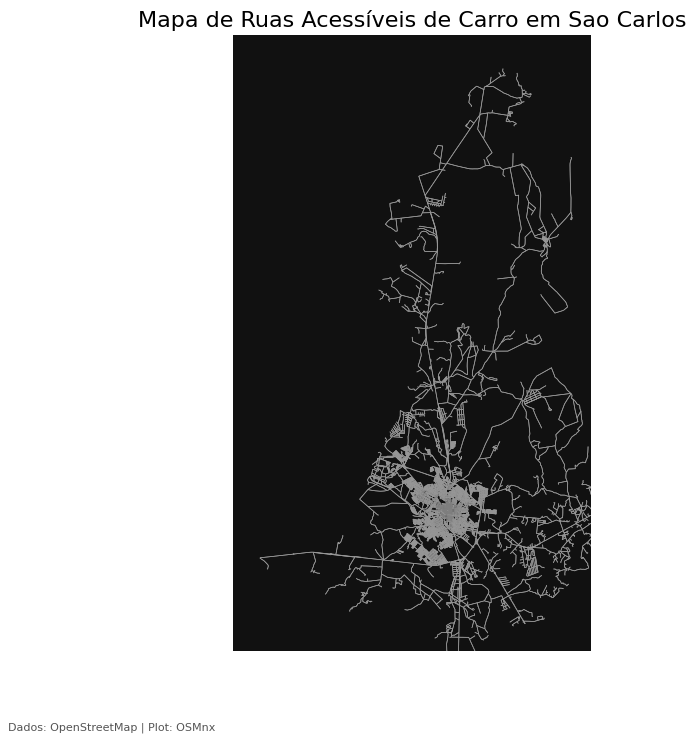

In [ ]:
# Crie uma figura e eixos para o plot
fig, ax = ox.plot_graph(mapa, node_size=0, edge_linewidth=0.5, show=False, close=False)

# Adicione o título
ax.set_title("Mapa de Ruas Acessíveis de Carro em Sao Carlos", fontsize=16)

# Adicione a legenda
ax.annotate("Dados: OpenStreetMap | Plot: OSMnx", xy=(0.01, 0.01), xycoords="figure fraction", ha="left", va="bottom", fontsize=8, color="#555555")

# Ajuste os limites do plot
margin = 0.02  # margem adicional em todos os lados
x_min, y_min, x_max, y_max = ax.axis()
ax.axis((x_min - margin, y_min - margin, x_max + margin, y_max + margin))

# Mostre o plot
plt.show()

In [ ]:
def distancia(graph, origin, destination):
    # Obtém o nó mais próximo das coordenadas de origem e destino
    origin_node = ox.distance.nearest_nodes(graph, origin[1], origin[0])
    destination_node = ox.distance.nearest_nodes(graph, destination[1], destination[0])

    # Calcula o caminho mais curto entre os nós
    route = nx.shortest_path(graph, origin_node, destination_node, weight='length')

    # Calcula a distância percorrida ao longo do caminho mais curto em metros
    distance = nx.shortest_path_length(graph, origin_node, destination_node, weight='length')

    return distance

#Função para inserir uma caixa no grafo
def coloca_caixa(grafo,caixa_nome, caixa_x, caixa_y, mapa, data_cheia=None):
  numero_caixa = len(grafo.nodes)

  if data_cheia is None:
        data_cheia = datetime.datetime.now()
  elif isinstance(data_cheia, str):
       data_cheia = datetime.datetime.strptime(data_cheia, '%Y-%m-%d')

  grafo.add_node(numero_caixa, nome = caixa_nome, x = caixa_x, y = caixa_y, tempo_cheia=data_cheia)
  for node in grafo.nodes:
    if(node != numero_caixa):
      ida = distancia(mapa,(grafo.nodes[numero_caixa]['x'], grafo.nodes[numero_caixa]['y']), (grafo.nodes[node]['x'], grafo.nodes[node]['y']))
      volta = distancia(mapa, (grafo.nodes[node]['x'], grafo.nodes[node]['y']), (grafo.nodes[numero_caixa]['x'], grafo.nodes[numero_caixa]['y']))
      grafo.add_edge(numero_caixa, node, weight=ida)
      grafo.add_edge(node, numero_caixa, weight=volta)


#Função para imprimir o grafo
def draw_bidirectional_graph(grafo):
    plt.figure(figsize=(15, 11))  # Set the size of the plot
    pos = nx.spring_layout(grafo, k=0.5, iterations=20)  # Adjust layout parameters

    nx.draw(grafo, pos, with_labels=False, node_color='skyblue', node_size=700, arrows=True)
    node_labels = {node: node for node in grafo.nodes()}
    nx.draw_networkx_labels(grafo, pos, labels=node_labels, verticalalignment='center', font_color='black')

    point_labels = {node: grafo.nodes[node]['nome'] for node in grafo.nodes()}
    label_pos = {k: [v[0], v[1] - 0.1] for k, v in pos.items()}
    nx.draw_networkx_labels(grafo, label_pos, labels=point_labels, verticalalignment='top', font_color='blue', font_size=10)

    edge_labels = {}
    for (u, v, data) in grafo.edges(data=True):
        if (v, u) in grafo.edges:
            if (v, u) not in edge_labels:
                weight_reverse = grafo[v][u]['weight']
                edge_labels[(u, v)] = f"ida: {data['weight']} | volta: {weight_reverse}"
        else:
            edge_labels[(u, v)] = f"ida: {data['weight']}"

    nx.draw_networkx_edge_labels(grafo, pos, edge_labels=edge_labels, label_pos=0.5, font_color='red', font_size=6)

    plt.margins(0.1)
    plt.axis('off')

    plt.show()


#Funções para imprimir matriz de expansão
def create_weight_matrix(grafo):
    n = len(grafo.nodes())
    # Criar uma matriz n x n preenchida com zeros
    matrix = [[0] * n for _ in range(n)]

    # Preencher a matriz com os pesos das arestas
    for u, v, data in grafo.edges(data=True):
        matrix[u][v] = data.get('weight', 0)
        if not grafo.is_directed():
            matrix[v][u] = data.get('weight', 0)

    return matrix

def print_weight_matrix(weight_matrix):
    num_columns = len(weight_matrix)

    header = "     " + "       ".join(f"{i:2}" for i in range(num_columns))
    print(header)
    print("   +" + "--------" * num_columns)

    for index, row in enumerate(weight_matrix):
        row_string = ', '.join(f"{weight:5.2f}" for weight in row)
        print(f"{index} | [{row_string}]")

In [ ]:
def ponto_inicio(caixa_nome, caixa_x, caixa_y, data):
    coloca_caixa(caixa,caixa_nome, caixa_x, caixa_y, mapa, data)

def ponto_final(caixa_nome, caixa_x, caixa_y, data):
    coloca_caixa(caixa,caixa_nome, caixa_x, caixa_y, mapa, data)

def inserir_ponto(caixa_nome, caixa_x, caixa_y, data):
    coloca_caixa(caixa,caixa_nome, caixa_x, caixa_y, mapa, data)

def imprimir_rota(lista_de_vertices):
    for i in lista_de_vertices:
      # i = 1 significa que estamos no vertice final: o salao de eventos
      if (i != 1):
        print(caixa.nodes[i]["nome"], "—> ", end='')
      else:
         print(caixa.nodes[i]["nome"])

#Implementação das buscas

### Implementação DFS

In [ ]:
def dfs_shortest_path(graph, source, target):

    """
    Encontra o menor caminho em um digrafo usando o algoritmo DFS.

    Parâmetros:
        graph (networkx.DiGraph): O digrafo.
        source: O nó de origem.
        target: O nó de destino.

    Retorna:
        O menor caminho como uma lista de nós.
    """

    # Função auxiliar para realizar a busca em profundidade recursivamente
    def dfs_recursive(node, path):

        # Se o nó atual for o destino, retornamos o caminho atual
        if node == target:

            # Se o caminho não alcançou as 5 caixas possíveis,
            # retornamos None para forçar o backtracking
            if len(path) != 6:
              return None

            return path + [node]

        # Para cada vizinho do nó atual
        for neighbor in graph.neighbors(node):

            # Se o vizinho não estiver no caminho atual
            if neighbor not in path:

                # Chamamos a função recursivamente para continuar a busca
                new_path = dfs_recursive(neighbor, path + [node])

                # Se encontrarmos um caminho válido, retornamos ele
                if new_path:
                    return new_path

        # Se nenhum caminho for encontrado, retornamos None
        return None

    # Chamamos a função de busca em profundidade recursiva a partir do nó de origem
    shortest_path = dfs_recursive(source, [])

    return shortest_path

### Implementação Best-First com heurística por economias


In [ ]:
# grafo = representação dos caminhos possíveis para buscar as caixas
# caminho_inicial = um array indicando o nó inicial e o nó de destino
def Add_Maior_Economia(grafo,caminho_inicial):
    R = caminho_inicial

    while True:
        economias = {}
        caminhos = {}

      # olha para os nós candidatos a entrar no meio do caminho existente
        for k in grafo.nodes:
            if k not in R:
                objeto = calcular_economia_insercao(grafo, R, k)
                economias[k] = objeto["economia"]
                caminhos[k] = objeto["caminho"]

        # garantir a quantidade máxima ideal de 5 caixas - encerra o programa
        if(len(R) > 14): break

        # encontra qual nó traz mais economia para ser inserido no caminho
        k_maior_economia = max(economias, key=economias.get)

        # insere o nó no caminho atual
        R = atualizar_valores(R, caminhos[k_maior_economia])

    return R


# Função para calcular a penalidade do vértice k
def penalidade_vertice(grafo, k):
    data_atual = datetime.datetime.now()
    dias_cheia = (data_atual - grafo.nodes[k]['tempo_cheia']).days
    penalidade = dias_cheia * 100
    return penalidade


def calcular_economia_insercao(grafo, R, k):
    economias_local = []

    # olha para os subcaminhos possiveis usando k dentro de R
    for i, j in zip(R[:-1], R[1:]):

        cij = grafo[i][j]['weight']  # Custo da aresta (i, j)
        cik = grafo[i][k]['weight'] if k in grafo[i] else 0  # Custo da aresta (i, k)
        ckj = grafo[k][j]['weight'] if k in grafo[j] else 0  # Custo da aresta (k, j)

        pk = penalidade_vertice(grafo, k)  # Penalidade do vértice k

        # calculo da economia para ir de i a j passando por k com penalidade pk
        economia_k = cij + pk - cik - ckj

        possivel_caminho = {"caminho": [i,k,j], "economia": economia_k}
        economias_local.append(possivel_caminho)

    # retorna, para todas as possibilidades possíveis de caminho passando por k, aquele com maior economia
    return max(economias_local, key=lambda x: x["economia"]) if economias_local else {"economia": 0, "caminho": []}

# Função para organizar o caminho
def atualizar_valores(R, subcaminho_com_k):
    posicao_troca = 0

    # encontra a posicao em que k deve entrar
    for index in range(len(R)):
      if R[index] == subcaminho_com_k[0]:
        posicao_troca = index + 1
        break;

    # faz o swap jogando todo mundo uma posicao pra frente
    R.append(subcaminho_com_k[1]) # elemento k novo no array
    for index in range(len(R) - 1, posicao_troca, -1):
      R[index] = R[index-1]

    # insere o k na posicao certa
    R[posicao_troca] = subcaminho_com_k[1]

    # retorna R "ordenado"
    return R

#Aplicação

In [ ]:
caixa = nx.DiGraph()

Cada nó do grafo terá quatro atributos:
- nome, o nome da caixa
- x, sua coordenada de latitude
- y, sua coordenada de longitude
- data que o local ligou informando que esta cheia, no formato YYYY-MM-AA

Cada aresta que liga os grafos contém a informação sobre a distância percorrida para ir do nó x para o nó y e vice-versa.

Para inserir uma caixa siga o seguinte modelo:

inserir_ponto('Nome local', x, y 'YYYY-MM-DD')

Pontos inicial e final são definidos previamente:
- Ponto inicial: Saida da matematica USP -> -22.006250, -47.895083
- Ponto final: Salão de eventos USP -> -22.004757, -47.896515

In [ ]:
ponto_inicio('ponto inicial',-22.004757, -47.896515, '2024-01-01')
ponto_final('ponto final',-22.004757, -47.896515, '2024-01-01')

##Inserções das caixas

Caixas pra buscar:
- Catedral de São Carlos -> -22.018534, -47.891584
- Uni Vestibulares -> -22.014723, -47.890783
- Embrapa Instrumentação -> -22.012392, -47.896302
- Tiquinho -> -22.007914, -47.890915
- Anglo Fudamental' -> -22.012394, -47.893155
- Jau loja 7 -> -22.013925, -47.887819
- Cibeu Idiomas -> -22.014172, -47.895196
- Cogeb -> -22.012529, -47.883880


In [ ]:
inserir_ponto('droga raia sf',-22.00927, -47.91445, '2024-05-01')
inserir_ponto('rosario sallum',-22.03069, -47.89807, '2024-05-01')
inserir_ponto('rosario shop passeio',-22.00933, -47.90578, '2024-05-01')
inserir_ponto('rosario santa felicia',-21.99741, -47.91542, '2024-05-01')
inserir_ponto('rosario vila ney',-22.01239, -47.87261, '2024-05-01')
inserir_ponto('tiquinho vila prado',-22.02522, -47.89859, '2024-05-01')
inserir_ponto('4life',-22.00794, -47.89116, '2024-05-01')
inserir_ponto('jau 7',-22.01391, -47.88801, '2024-05-01')
inserir_ponto('jau 10',-22.01164, -47.87276, '2024-05-01')
inserir_ponto('jau 13',-22.03299, -47.9026, '2024-05-01')
inserir_ponto('sevegnago',-22.00491, -47.90462, '2024-05-01')
inserir_ponto('cibeu',-22.01435, -47.89514, '2024-05-01')
inserir_ponto('objetivo fund i',-22.00888, -47.88511, '2024-05-01')

#####Representação do grafo

Para poder representar o grafico graficamente, rode o comando abaixo:

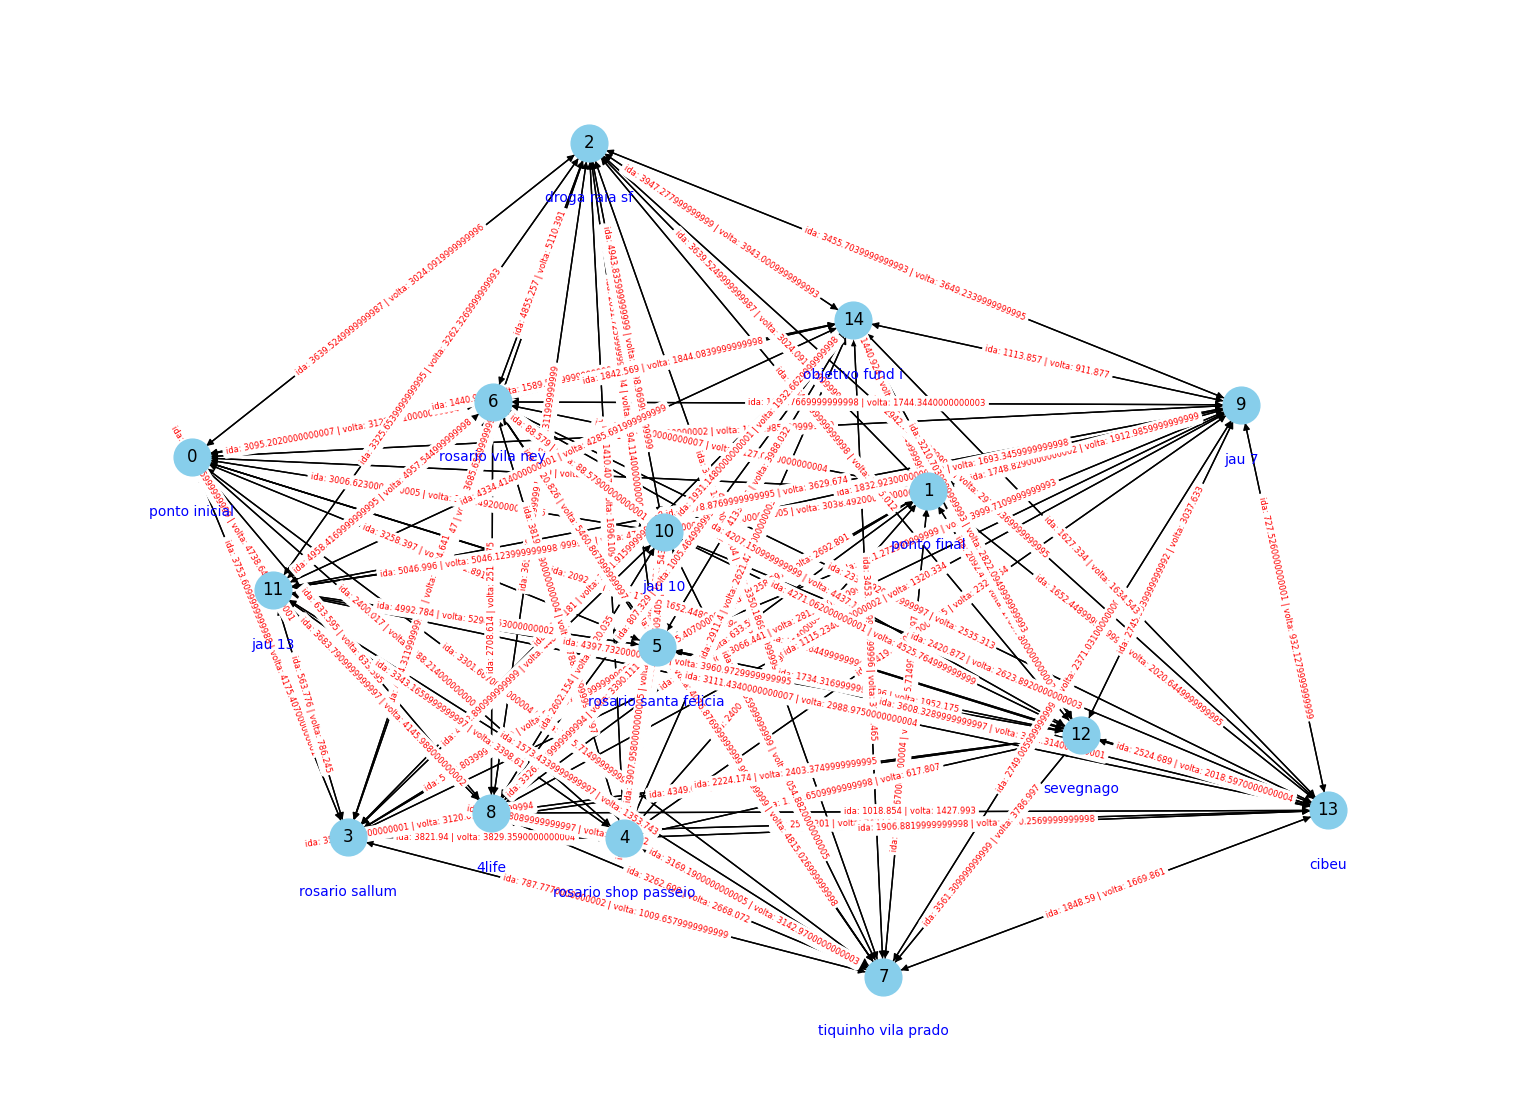

In [ ]:
draw_bidirectional_graph(caixa)

Se deseja representar o grafo como uma matriz de expansão, rode os comandos abaixo:

In [ ]:
weight_matrix = create_weight_matrix(caixa)
print_weight_matrix(weight_matrix)

      0        1        2        3        4        5        6        7        8        9       10       11       12       13       14
   +------------------------------------------------------------------------------------------------------------------------
0 | [ 0.00,  0.00, 3639.52, 3753.61, 2400.02, 3258.40, 3095.20, 3301.67, 633.60, 1748.83, 3006.62, 4317.39, 2092.46, 1652.45, 1440.92]
1 | [ 0.00,  0.00, 3639.52, 3753.61, 2400.02, 3258.40, 3095.20, 3301.67, 633.60, 1748.83, 3006.62, 4317.39, 2092.46, 1652.45, 1440.92]
2 | [3024.09, 3024.09,  0.00, 3811.85, 1410.41, 2031.73, 4855.26, 3477.17, 3657.69, 3455.70, 4943.84, 3325.65, 1564.20, 2942.76, 3947.28]
3 | [4175.41, 4175.41, 3685.66,  0.00, 3821.94, 5602.80, 4394.31, 787.78, 3582.76, 3066.44, 4482.89, 563.78, 4349.09, 2548.20, 3771.18]
4 | [1988.21, 1988.21, 1696.11, 3829.36,  0.00, 2705.66, 3819.38, 3169.19, 2621.81, 2419.83, 3907.96, 3343.17, 1373.65, 1906.88, 2911.40]
5 | [2692.89, 2692.89, 1794.11, 5478.98, 2277.53,  0.00, 55

##Busca de rotas

Obter uma rota, por meio de uma busca dfs

In [ ]:
# Argumentos: caixa (grafo), (ponto inicial predefinido), (ponto final predefinido)
print(dfs_shortest_path(caixa, 0, 1))
imprimir_rota(dfs_shortest_path(caixa, 0, 1))

[0, 2, 3, 4, 5, 6, 1]
ponto inicial —> Catedral —> uni vestibulares —> embrapa —> tiquinho —> anglo fudamental —> ponto final


Obter uma rota, por meio da busca por ecomonias (heuristica):

In [ ]:
#Ponto inicial e final predefinidos
caminho_inicial= [0,1]

#Busca
vertices_selecionados = Add_Maior_Economia(caixa,caminho_inicial)
print(vertices_selecionados)
imprimir_rota(vertices_selecionados)

[0, 8, 14, 6, 10, 9, 13, 3, 11, 7, 12, 5, 2, 4, 1]
ponto inicial —> 4life —> objetivo fund i —> rosario vila ney —> jau 10 —> jau 7 —> cibeu —> rosario sallum —> jau 13 —> tiquinho vila prado —> sevegnago —> rosario santa felicia —> droga raia sf —> rosario shop passeio —> ponto final
